# Subpopulation Discovery in Bladder Cancer Proteomics (Level 1)

This notebook identifies patterns in a bladder cancer proteomics dataset using unsupervised learning.

**Course:** Omics for Non-Biologists  
**Group name:** Genomics  

**Group members:**  
- Ke Wang
- Carla Malo
- Marc Nanzer
- Jiayi Ma
- Choekyel Nyungmartsang

**Expected input files**

- `../data/proteomics.txt` (required): protein abundance matrix
- `../data/metadata.csv` (optional): clinical metadata
- `./src/` (required): helper functions used in this notebook

**Dataset**

- 140 patients
- 3,120 proteins
- Each value represents the measured abundance of one protein in one patient

**Level 1 goal**

- Build an unsupervised pipeline to group patients into clusters based on their protein profiles
- Justify the number of clusters using quantitative metrics and visual evidence

**Planned approach**

- Reduce dimensionality using PCA
- Apply KMeans clustering in the reduced space
- Evaluate clustering using elbow analysis, silhouette scores, and 2D visualizations (PCA and UMAP)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from sklearn.covariance import LedoitWolf

REQUIRED_FILES = ["../data/proteomics.txt"]
for f in REQUIRED_FILES:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing required input file: {f}")

if not os.path.isdir("./src"):
    raise FileNotFoundError(
        "Missing required folder './src'. "
        "Please include the 'src' directory containing 'bladder_proteomics' with the submission."
    )

from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.preprocessing import log1p_transform, zscore_normalize, variance_filter, log2_transform, median_center_rows
from src.bladder_proteomics.dimensionality_reduction import apply_pca, pca_elbow, apply_umap, pc_names, compare_pca_diagnostics
from src.bladder_proteomics.clustering import kmeans_cluster
from src.bladder_proteomics.k_selection import elbow_method, silhouette_analysis, calculate_elbow_point, evaluate_k_selection_one, ari_stability_init, passes_min_cluster_size, pc_sensitivity_best_k
from src.bladder_proteomics.plotting import (get_cluster_colors, plot_2d_embedding,
                          plot_cluster_distributions, plot_cluster_sizes,
                          plot_clusters, plot_elbow, plot_heatmap,
                          plot_log10_raw_distribution,
                          plot_median_centering_diagnostics, plot_pca,
                          plot_pca_cumulative_variance,
                          plot_pca_scatter_with_outliers, plot_pca_variance,
                          plot_scree_and_cumulative, plot_silhouette_scores,
                          plot_umap, set_plot_style, plot_k_selection_grid,
                          overlay_flagged_outliers_on_clean_pca)
set_plot_style(dpi=120)

## 1. Data overview and preprocessing

### Data orientation
- The proteomics file is loaded as a table with **rows = patients** and **columns = proteins**.

### Preprocessing goals
- Make abundance values comparable across proteins and patients.
- Reduce the number of uninformative or redundant protein features before clustering.
- Flag extreme patient profiles as potential outliers (tracked separately; not automatically removed).

### Steps
1. Load the proteomics matrix and run basic validation checks (shape, missingness, duplicates, value range).
2. Remove protein features with **identical expression profiles across patients** (redundant features).
3. Visualize the raw dynamic range using a log10 histogram (diagnostic only).
4. Apply a **log2 transform** to compress the dynamic range (only valid for non-negative values).
   - If zeros exist, add a small pseudo-count; otherwise use log2(x) without an offset.
5. Normalize each patient by **median centering on the log2 scale** to reduce global sample-to-sample intensity shifts.
6. Remove (near) constant proteins and select the **top 20% most variable proteins** on the log2 scale.
7. Standardize selected proteins (**z score per protein**) so PCA and KMeans are driven by patterns rather than measurement scale.
8. Fit PCA and compute Mahalanobis distance in PCA space to flag potential outlier patients for sensitivity analysis.

### Notes on key choices
- **Log2 transform:** Raw proteomics values span a very large range. Log2 compresses extremes and is common in proteomics (fold changes become interpretable on a base-2 scale).
- **Median centering (sample-level):** Proteomics samples can differ in overall intensity due to technical effects (loading amount, instrument drift). Median centering reduces global shifts so clustering focuses more on relative protein patterns. This may also remove real biological “global intensity” effects, so we treat it as a practical normalization choice and report sensitivity checks.
- **Feature selection (top 20% by variance):** We reduce dimensionality by keeping proteins that vary most across patients on the log2 scale. This is mainly for denoising and dimensionality reduction.
- **Outlier flagging (not removal):** Outliers are flagged using Mahalanobis distance in PCA space and are not automatically removed. We later compare clustering results with and without flagged samples to check robustness.

In [2]:
# Load + validate
df = load_data("../data/proteomics.txt", transpose=True, index_col=0, sep="\t")
validate_data(df)
print(f"Raw value range: min={df.min().min():.4g}, max={df.max().max():.4g}")

Removed proteins with identical profiles: 9
Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Raw value range: min=1.163, max=7.19e+20


The raw protein abundances span a very large dynamic range (up to ~7e20).  
To make patterns comparable across patients and reduce the impact of extreme values, we transform the data to a log scale.  
We use **log2** because it is commonly used in proteomics (fold changes become interpretable on a base 2 scale).

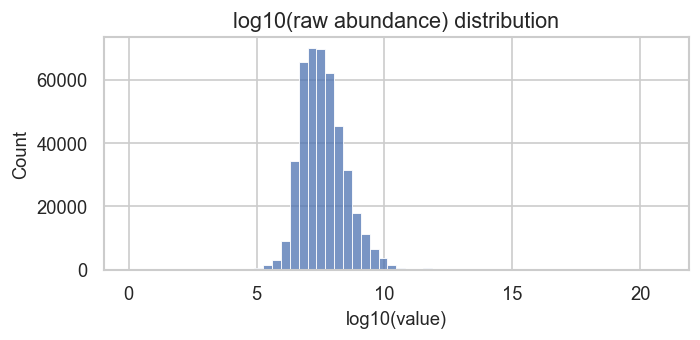

In [3]:
# log10(raw) distribution (interpretable dynamic range)
plot_log10_raw_distribution(df)
plt.tight_layout()
plt.show()

*Figure: Histogram of log10-transformed raw abundance values pooled across all proteins and patients.  
This is a quick diagnostic to show the extreme dynamic range of the raw measurements and motivate log-scale preprocessing.  
All downstream preprocessing uses a log2 transformation for interpretability.*

In [4]:
# log2 transform
df_log2, log_info = log2_transform(df, pseudocount="auto")
print("log2 transform info:", log_info)

log2 transform info: {'has_zero': 0.0, 'pseudocount_used': 0.0}


### Sample-level normalization: median centering (log2 scale)

To reduce global sample-to-sample intensity shifts, we subtract each patient’s **median log2 abundance** from all proteins in that patient.

We show:
- the distribution of per-patient median log2 intensities **before** centering
- and that these medians are aligned around zero **after** centering (by construction)

A more informative visualization (density curves across several patients) can be seen in the Supplement section S1A.



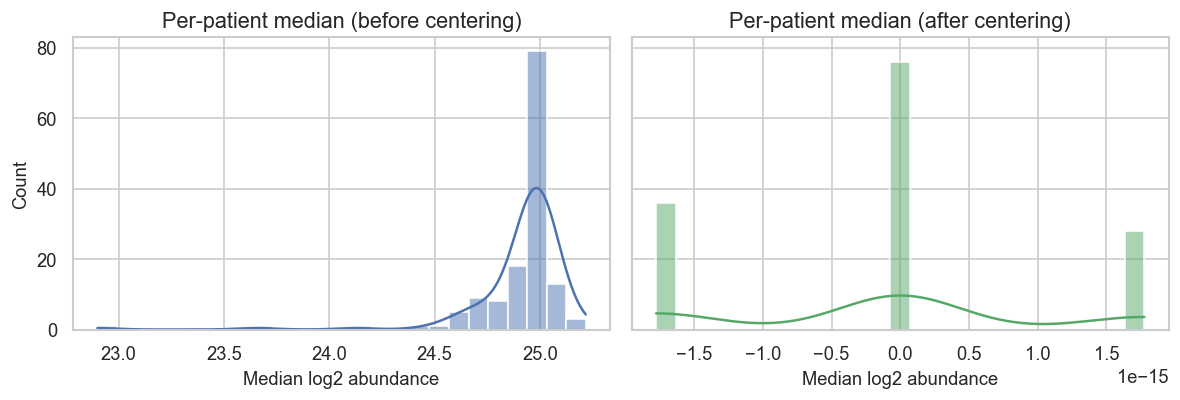

In [5]:
# median centering + diagnostic plots
df_log2_before = df_log2.copy()
df_log2 = median_center_rows(df_log2)
fig1 = plot_median_centering_diagnostics(df_log2_before, df_log2)
plt.show()

*Figure: Diagnostic plots for median centering on the log2 scale.  
Left: per patient median log2 intensity before centering. Right: after centering the median is aligned around zero by construction.*  

The density curves in the supplementary section show that centering reduces global intensity shifts across patients while keeping the overall shape of protein distributions similar.

We select the top 20 percent most variable proteins **before z score scaling**, because z scoring would force all proteins to have similar variance and would remove the basis for variance based feature selection.

In [6]:
# Feature selection: top 20% by variance on log scale
top_fraction = 0.20
variances = df_log2.var(axis=0).sort_values(ascending=False)
k = max(2, int(len(variances) * top_fraction))
top_features = variances.index[:k]
df_sel_log = df_log2.loc[:, top_features].copy()
print(f"After feature selection (top {int(top_fraction*100)}% by variance): {df_sel_log.shape}")

After feature selection (top 20% by variance): (140, 622)


In [7]:
# Z-score per protein for PCA/KMeans
df_scaled = zscore_normalize(df_sel_log, axis=0)

### Outlier flagging in PCA space (Mahalanobis distance)

We fit PCA on the standardized data and compute Mahalanobis distances in the retained PCA space.
Patients above a high chi-square threshold are **flagged as potential outliers**.

This step is used for sensitivity analysis (clustering with and without flagged samples).  
It does not prove biological distinctness and can reflect technical effects or distributional deviations from the model assumptions.

In [8]:
# Outlier flagging in PCA space (Mahalanobis with shrinkage covariance)
pca_var_target = 0.80
pca_df, pca_model = apply_pca(df_scaled, n_components=pca_var_target, return_model=True)
pca_df = pc_names(pca_df)

n_pc = pca_df.shape[1]
X = pca_df.values

lw = LedoitWolf().fit(X)
mu = lw.location_
precision = lw.precision_

mahal_dist = np.einsum("ij,jk,ik->i", (X - mu), precision, (X - mu))

confidence_level = 0.999
threshold = chi2.ppf(confidence_level, df=n_pc)

is_outlier = pd.Series(mahal_dist > threshold, index=df_scaled.index, name="is_outlier")

df_scaled_all = df_scaled.copy()
df_scaled_clean = df_scaled.loc[~is_outlier].copy()
df_scaled_outliers = df_scaled.loc[is_outlier].copy()

print(f"PCA outlier flagging: n_PC={n_pc}, chi2@{confidence_level} threshold={threshold:.3f}")
print(f"Outliers flagged: {int(is_outlier.sum())}/{len(is_outlier)}")
print("Scaled set shape (all):", df_scaled_all.shape)
print("Scaled set shape (clean):", df_scaled_clean.shape)
print("Scaled outliers shape:", df_scaled_outliers.shape)

PCA outlier flagging: n_PC=8, chi2@0.999 threshold=26.124
Outliers flagged: 12/140
Scaled set shape (all): (140, 622)
Scaled set shape (clean): (128, 622)
Scaled outliers shape: (12, 622)


In [9]:
# Most extreme Mahalanobis distances (sanity check)
top_md = pd.Series(mahal_dist, index=df_scaled.index).sort_values(ascending=False).head(15)
print("\nTop 15 Mahalanobis distances:")
print(top_md)


Top 15 Mahalanobis distances:
BC.11    114.232765
BC.9     100.669213
BC.10     87.217374
BC.1      82.137596
BC.12     70.672585
BC.4      68.213189
BC.2      46.994329
BC.3      43.938565
BC.7      40.667147
BC.5      40.112555
BC.8      39.701852
BC.6      38.300441
BC.13      5.006813
BC.14      4.201169
BC.15      3.879939
dtype: float64


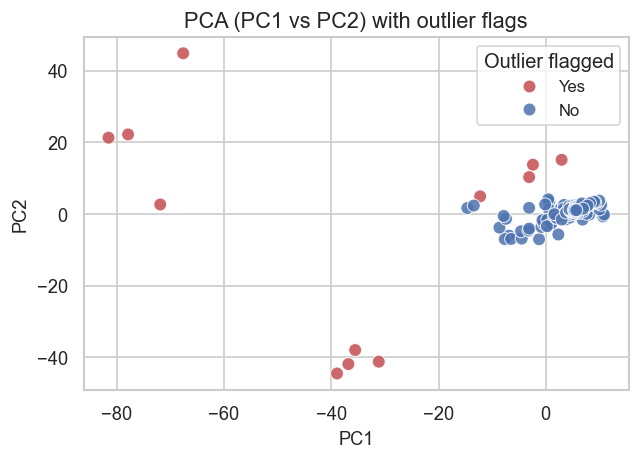

In [10]:
# PCA scatter with outlier flags
pca2 = pca_df.iloc[:, :2].copy()  # already PC1/PC2 if pc_names applied
plot_pca_scatter_with_outliers(pca2, is_outlier)
plt.tight_layout()
plt.show()

*Figure: PCA (PC1 vs PC2) of the standardized proteomics data (top-variable proteins).  
Patients flagged as potential outliers (Mahalanobis distance in PCA space) are highlighted for sensitivity analysis and are not automatically removed.*

Additional QC checks (Supplementary): We ran two lightweight robustness checks: (i) a near-constant protein filter (no proteins removed in this cohort), and (ii) a proxy sample-order check using PC1 versus file order (interpretation limited without batch metadata). Results are shown in Supplementary S1B–C.

## 2. Dimensionality reduction with PCA

We apply PCA to the preprocessed protein matrix (log2-transformed, median-centered per patient, variance-selected, and z-scored) for two purposes:

- **Input for clustering:** KMeans uses Euclidean distance, which can become less informative in very high dimensions (distances concentrate and noise can dominate). PCA provides a lower-dimensional representation that captures the strongest variance patterns.
- **Visualization:** The first two PCs provide a simple 2D view of major structure and help visualize flagged outliers.

**Important:** The scree plot (explained variance curve) is a diagnostic of dimensionality. It does not directly determine the best number of PCs for clustering. We later validate the final PCA dimensionality using clustering metrics (silhouette and stability) across multiple PC counts.

To check robustness, we compute PCA on:
- the **full dataset**, and
- a **clean dataset** excluding flagged outliers.

This allows us to see whether extreme samples disproportionately influence the variance structure captured by PCA.

In [11]:
# PCA on FULL and CLEAN set (use enough PCs for a reliable scree diagnostic)
pca_diag = compare_pca_diagnostics(df_scaled_all, df_scaled_clean, max_pcs=50, var_threshold=0.80)

pca_full_df = pca_diag["full"]["scores"]
pca_clean_df = pca_diag["clean"]["scores"]

print(f"[FULL] Elbow (explained-variance curve): PC = {pca_diag['full']['elbow_pc']}")
print(f"[FULL] PCs to reach 80% variance: {pca_diag['full']['pc80']}")
print()
print(f"[CLEAN] Elbow (explained-variance curve): PC = {pca_diag['clean']['elbow_pc']}")
print(f"[CLEAN] PCs to reach 80% variance: {pca_diag['clean']['pc80']}")

[FULL] Elbow (explained-variance curve): PC = 7
[FULL] PCs to reach 80% variance: 8

[CLEAN] Elbow (explained-variance curve): PC = 5
[CLEAN] PCs to reach 80% variance: 17


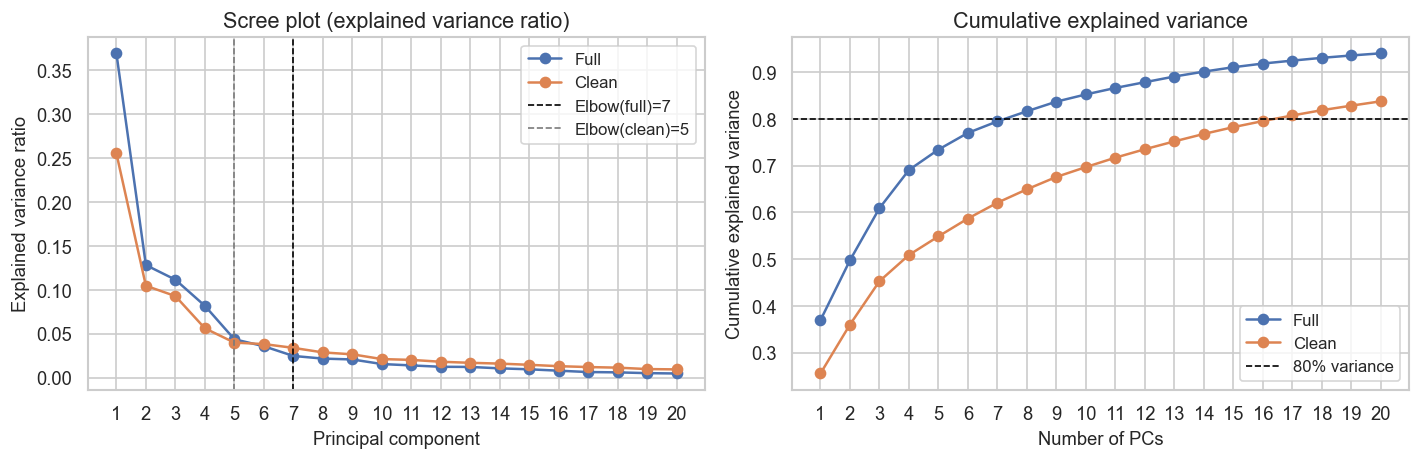

In [12]:
# Plot scree + cumulative (both full and clean) - show first 20 for readability
fig = plot_scree_and_cumulative(
    explained_full=pca_diag["full"]["explained"],
    explained_clean=pca_diag["clean"]["explained"],
    elbow_full=pca_diag["full"]["elbow_pc"],
    elbow_clean=pca_diag["clean"]["elbow_pc"],
    var_line=0.80,
    plot_n=20,
    int_xticks=True,   # <- fixes your .5 tick issue
)
plt.show()

*Figure: Scree plot (left) and cumulative explained variance (right) for PCA on the full dataset and on the dataset excluding flagged outliers.  
These curves are used as diagnostics of PCA dimensionality. The final number of PCs used for clustering is treated as a tuning parameter and is validated later using clustering metrics (silhouette and stability).*

**Finding:** The scree and cumulative-variance curves are broadly similar for the full and clean sets, suggesting that outlier removal does not change the overall PCA structure. The elbow occurs at PC=7 (full) versus PC=5 (clean), while the number of PCs needed to reach 80% cumulative variance differs substantially (8 in full vs 17 in clean). This indicates that flagged extremes can inflate variance captured by early PCs in the full dataset. Therefore, we treat PCA dimensionality as a tuning parameter and validate the final number of PCs later using clustering metrics (silhouette and stability).

## 3. Clustering methodology

We cluster patients using **KMeans** applied to a **PCA embedding** of the preprocessed protein matrix.

- **Why KMeans:** KMeans is a widely used baseline for clustering continuous data. It is computationally simple and provides an interpretable partition of patients into groups based on Euclidean distances in the chosen feature space. We treat KMeans clusters as *candidate* patient subgroups that require validation (robustness checks and downstream interpretation).
- **Why PCA before KMeans:** High-dimensional omics data can make Euclidean distances less informative. PCA provides a lower-dimensional representation and produces **uncorrelated principal components** that capture the main variance directions used for clustering.
- **Distance metric:** After per-protein z-score standardization and PCA reduction, **Euclidean distance in PCA space** is a reasonable choice for KMeans because all dimensions are on a comparable scale.

We treat the **number of PCs used for clustering** as a tuning parameter. We start with a small number of PCs suggested by the scree elbow, and later validate conclusions across multiple PC counts using clustering metrics (silhouette and stability) and sensitivity analyses (full vs clean datasets).

In [13]:
# PCA embeddings used for clustering (FULL and CLEAN versions)
# We will evaluate clustering across multiple PCA dimensions (tuning parameter).
pc_grid = [2, 3, 5, 8, 10, 15, 20]

X_pca_full_dict = {k: pca_full_df.iloc[:, :k].copy() for k in pc_grid}
X_pca_clean_dict = {k: pca_clean_df.iloc[:, :k].copy() for k in pc_grid}

for k in pc_grid:
    print(f"PCs={k:<2}: X_full={X_pca_full_dict[k].shape}, X_clean={X_pca_clean_dict[k].shape}")

PCs=2 : X_full=(140, 2), X_clean=(128, 2)
PCs=3 : X_full=(140, 3), X_clean=(128, 3)
PCs=5 : X_full=(140, 5), X_clean=(128, 5)
PCs=8 : X_full=(140, 8), X_clean=(128, 8)
PCs=10: X_full=(140, 10), X_clean=(128, 10)
PCs=15: X_full=(140, 15), X_clean=(128, 15)
PCs=20: X_full=(140, 20), X_clean=(128, 20)


## 4. Determining the number of clusters

We evaluate candidate numbers of clusters K using complementary diagnostics:

- **Elbow (inertia / WCSS):** shows diminishing returns in within-cluster dispersion as K increases. This is a rough diagnostic and often decreases smoothly.
- **Silhouette score:** measures how separated clusters are in the chosen embedding. However, silhouette can be artificially high when a few extreme samples form very small clusters.

To reduce the risk of selecting K based on artifacts, we add two robustness checks (Supplement section S4):

- **Cluster-size sanity check:** we flag solutions dominated by very small clusters, because these often reflect outliers rather than stable cohort subpopulations.
- **Stability (ARI across KMeans initializations):** we compute KMeans with a single random seed and measure agreement (ARI). This measures sensitivity to initialization, not sampling variability.

We run K selection on:
- the **full dataset**, and
- a **clean dataset** excluding flagged outliers,

because extreme samples can dominate Euclidean clustering and inflate silhouette scores.

**Decision rule:** We prefer the smallest K that (i) has reasonable separation, (ii) does not rely on tiny clusters, and (iii) is stable across reasonable PCA dimensions and the outlier sensitivity check.

[FULL]  elbow_k=6 | best_k_sil=4 (score=0.813)
[CLEAN] elbow_k=6 | best_k_sil=2 (score=0.367)


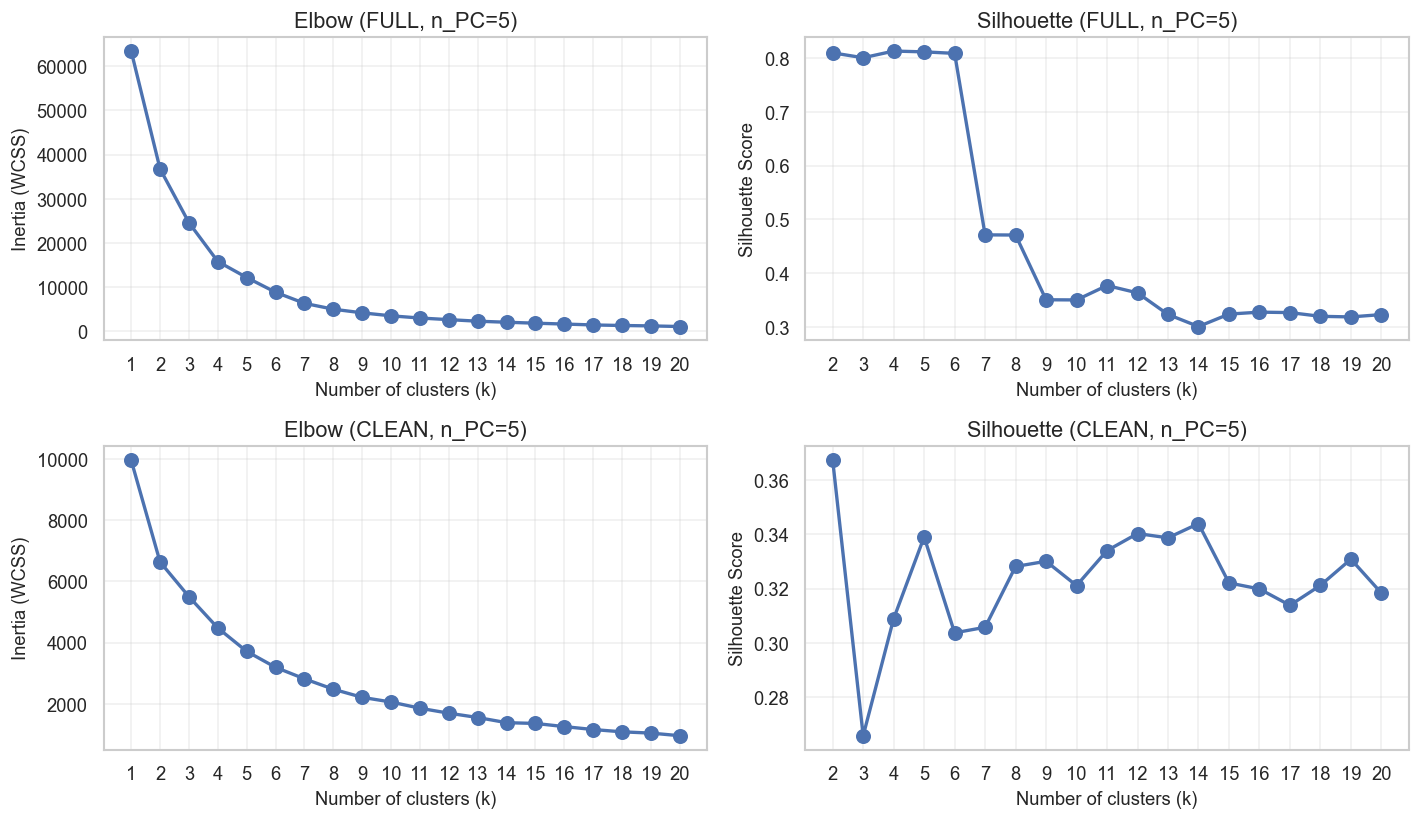

In [14]:
# K selection (FULL vs CLEAN) at a baseline PCA dimension
k_max = 20
n_pc = 5

X_pca_full = pca_full_df.iloc[:, :n_pc].copy()
X_pca_clean = pca_clean_df.iloc[:, :n_pc].copy()

res_full = evaluate_k_selection_one(X_pca_full, k_max=k_max)
res_clean = evaluate_k_selection_one(X_pca_clean, k_max=k_max)

print(f"[FULL]  elbow_k={res_full['elbow_k']} | best_k_sil={res_full['best_k_sil']} (score={res_full['best_sil']:.3f})")
print(f"[CLEAN] elbow_k={res_clean['elbow_k']} | best_k_sil={res_clean['best_k_sil']} (score={res_clean['best_sil']:.3f})")

plot_k_selection_grid(res_full, res_clean, n_pc=n_pc)
plt.tight_layout()
plt.show()

*Figure: Elbow (inertia) and silhouette curves for KMeans clustering using the first 5 PCs.  
The elbow is a rough diagnostic for diminishing returns, while silhouette reflects separation but can be inflated by tiny clusters.*

**Result (FULL vs CLEAN, n_PC=5):**  
On the full dataset, the best silhouette occurs at K=4, but this corresponds to one dominant cluster and three very small clusters (128 + 4 + 4 + 4). This pattern can strongly inflate silhouette and is not treated as evidence for four stable patient subpopulations.  
On the clean dataset, the best silhouette occurs at K=2 with moderate separation (silhouette ≈ 0.37) and reasonable cluster sizes (87 and 41).  
We therefore treat K selection as sensitive to extreme samples and carry **K=2 on the clean dataset** forward as the most defensible coarse partition in this embedding.

In [15]:
# Sanity check: cluster sizes for best silhouette solutions
labels_full_best = pd.Series(
    kmeans_cluster(X_pca_full, n_clusters=res_full["best_k_sil"], align_labels=True),
    index=X_pca_full.index
)
labels_clean_best = pd.Series(
    kmeans_cluster(X_pca_clean, n_clusters=res_clean["best_k_sil"], align_labels=True),
    index=X_pca_clean.index
)

print("FULL best-k cluster sizes:")
print(labels_full_best.value_counts().sort_index())

print("\nCLEAN best-k cluster sizes:")
print(labels_clean_best.value_counts().sort_index())

FULL best-k cluster sizes:
0      4
1      4
2      4
3    128
Name: count, dtype: int64

CLEAN best-k cluster sizes:
0    41
1    87
Name: count, dtype: int64


**Sanity check (cluster sizes):** The full-dataset silhouette optimum at K=4 corresponds to one dominant cluster and three very small clusters. Such tiny clusters can inflate silhouette scores and are not treated as evidence for additional robust subpopulations.

**Stability (initialization sensitivity):** We evaluate robustness to KMeans initialization using mean pairwise ARI across repeated runs with different random seeds (n_init=1; Supplement S4B). This isolates sensitivity to initialization (separate from solution quality, where the final model uses a larger n_init).

We additionally verified that the silhouette-preferred K on the clean dataset remains K=2 across a range of retained PC counts (Supplement S4A)

**Interim conclusion:**  
Across PCA dimensions, the full dataset repeatedly produces very small clusters with high silhouette scores, consistent with clustering being dominated by extreme samples.  
In contrast, the clean dataset consistently supports **K=2** as the best silhouette choice across tested PC counts, with reasonable cluster sizes.  
We therefore carry **K=2 (clean dataset)** forward as the primary candidate for cohort-level structure, and treat flagged extreme samples as a sensitivity factor rather than defining additional subpopulations from them. On the clean dataset, K=2 is not only silhouette-preferred and size-valid, but also shows high initialization stability (Supplement S4B).

## 5. Cluster visualization on the clean dataset

We fit KMeans with **K=2** on the **clean dataset** (patients excluding flagged extreme samples), using the first **5 PCs** as input.

We visualize the result using:
- **PCA scatter (PC1 vs PC2):** a 2D view for interpretability only (clustering is performed in the 5D PCA space).
- **Cluster size bar plot:** confirms that the chosen solution is not driven by tiny clusters.

We also report the **silhouette score** of the final K=2 solution on the full 5D embedding as a compact summary of separation.

Clean set size: 128
Clean set silhouette (K=2, n_PC=5): 0.367


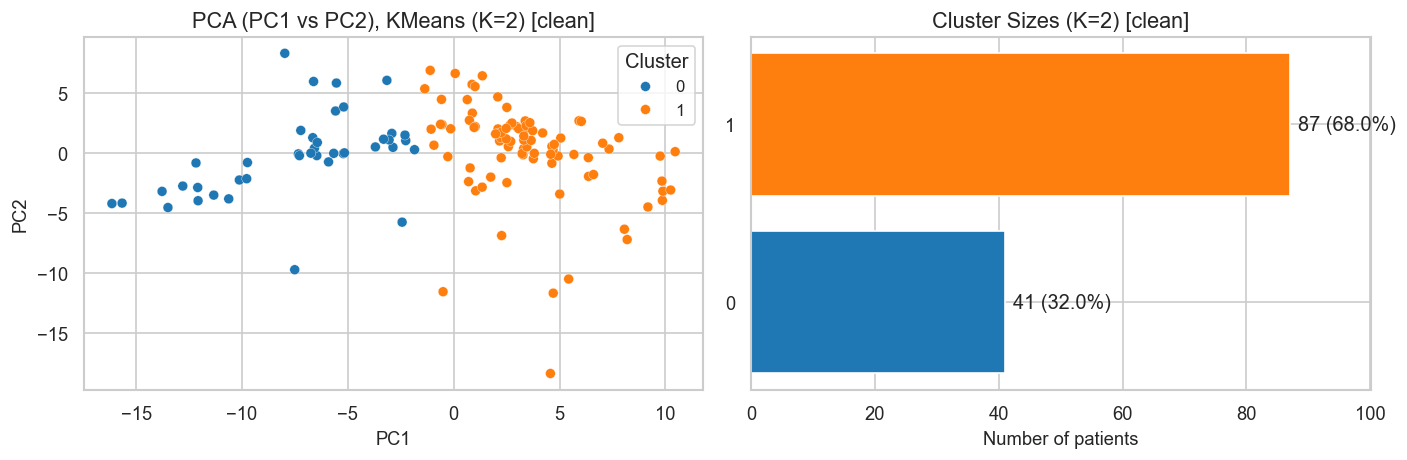

In [17]:
# Final visualization (CLEAN set)
final_k = 2
n_pc = 5  # consistent with Sections 3–4

# Use the clean embedding defined earlier (128 x 5)
X_vis = X_pca_clean.copy()
assert X_vis.shape[1] == n_pc, "Expected clean PCA embedding with n_pc columns."

# Fit KMeans on clean set
labels_clean = pd.Series(
    kmeans_cluster(X_vis, n_clusters=final_k, align_labels=True),
    index=X_vis.index,
    name="label",
)

print("Clean set size:", X_vis.shape[0])

# Report silhouette on the actual clustering space (5D PCA embedding)
sil_final = silhouette_score(X_vis, labels_clean.values)
print(f"Clean set silhouette (K={final_k}, n_PC={n_pc}): {sil_final:.3f}")

# Plot on the first two PCs for visualization
pca2_clean = X_vis.iloc[:, :2].copy()
pca2_clean = pc_names(pca2_clean)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_2d_embedding(pca2_clean, labels_clean, title=f"PCA (PC1 vs PC2), KMeans (K={final_k}) [clean]", ax=axes[0])
plot_cluster_sizes(labels_clean, title=f"Cluster Sizes (K={final_k}) [clean]", ax=axes[1])
plt.tight_layout()
plt.show()

*Figure: PCA scatter (left) and cluster size distribution (right) for the KMeans solution on the clean dataset (n=128).  
The plot is consistent with two broad groups in the clean cohort, but biological interpretation requires downstream analysis (e.g., protein-level differences or clinical associations).*

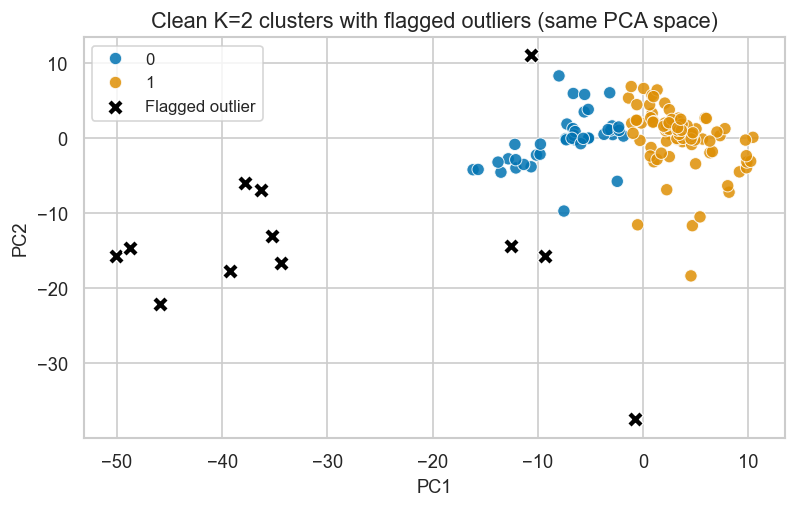

In [18]:
# Outlier context overlay (clean PCA fit, transform outliers)
_ = overlay_flagged_outliers_on_clean_pca(
    df_scaled_clean=df_scaled_clean,
    df_scaled_outliers=df_scaled_outliers,
    labels_clean=labels_clean,
    n_pc=n_pc,
    title="Clean K=2 clusters with flagged outliers (same PCA space)",
)
plt.show()

**Outlier context:** The plot above overlays the clean K=2 clustering onto the full PCA view and marks flagged outliers. This helps verify that extreme samples occupy distinct regions of PCA space and can dominate clustering on the full dataset.

## 6. Interim cluster count decision for Level 1

**Selected cluster count (clean dataset): K = 2.**

This decision is based on the following evidence (Sections 4–5):

- **Outlier sensitivity (full dataset):** On the full dataset, KMeans often produces one dominant cluster plus one or more very small clusters (frequently composed of flagged extreme samples). Such tiny clusters can inflate silhouette scores and are not treated as evidence for stable cohort-level subpopulations.

- **Separation on the clean set:** After excluding flagged extreme samples (clean dataset, n = 128) and clustering in the **n_PC = 5** PCA embedding, **K = 2** yields the highest silhouette score among the tested K values and produces reasonable cluster sizes (87 and 41).

- **Initialization stability:** Re-running KMeans with different random seeds (with a fixed `n_init` setting) yields high agreement (ARI) for **K = 2** on the clean set, indicating low sensitivity to initialization for this coarse partition.

We therefore carry **K = 2** forward as the primary coarse clustering structure for Level 1.  
Flagged extreme samples are **not deleted**; they are retained for sensitivity reporting and can be revisited separately if the goal is to model rare or extreme patient profiles rather than the main cohort structure.

# 7. Supplementary analyses (sensitivity checks)

This section contains additional robustness checks that support (but do not replace) the main K decision.

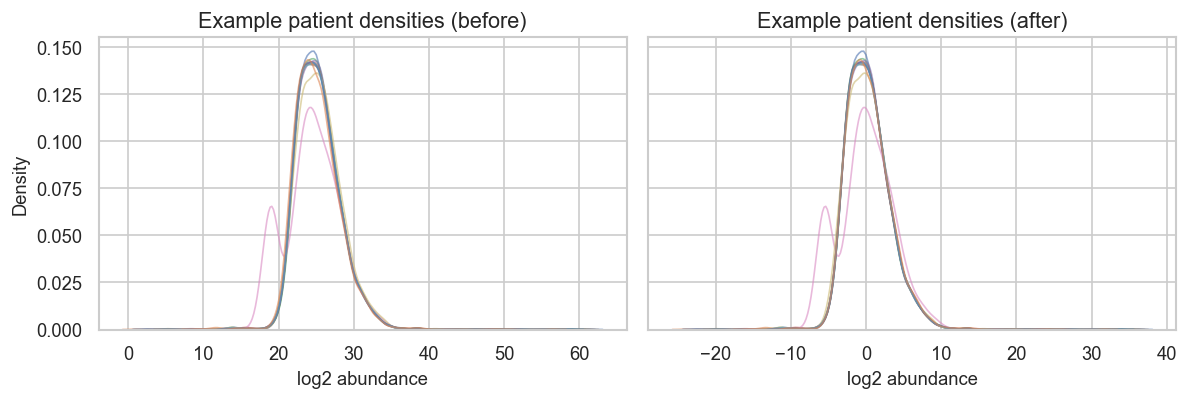

In [19]:
# S1A: Patient density curves before/after centering
rng = np.random.default_rng(42)
sample_ids = df_log2_before.index.to_numpy()
subset = rng.choice(sample_ids, size=min(12, len(sample_ids)), replace=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

for sid in subset:
    sns.kdeplot(df_log2_before.loc[sid].values, ax=axes[0], alpha=0.6, linewidth=1)
axes[0].set_title("Example patient densities (before)")
axes[0].set_xlabel("log2 abundance")

for sid in subset:
    sns.kdeplot(df_log2.loc[sid].values, ax=axes[1], alpha=0.6, linewidth=1)
axes[1].set_title("Example patient densities (after)")
axes[1].set_xlabel("log2 abundance")

plt.tight_layout()
plt.show()

In [20]:
# S1B: Checked and removed (near) constant proteins (if any)
var_eps = 0.00000001
variances = df_log2.var(axis=0)
keep_nonconstant = variances > var_eps
n_removed = int((~keep_nonconstant).sum())
df_log = df_log2.loc[:, keep_nonconstant]
print(f"[Supplementary S1B] Near-constant proteins removed: {n_removed}")

[Supplementary S1B] Near-constant proteins removed: 0


### Proxy check for ordering/run effects (limited without metadata)

We observed that some flagged outliers occur early in the sample order.  
Without explicit batch metadata, we do not claim a batch effect.  
Instead, we run a simple proxy check by plotting PC1 versus the sample index in file order.
A strong relationship would motivate sensitivity analysis (clustering with and without flagged samples).

Correlation between sample order and PC1: r = 0.524


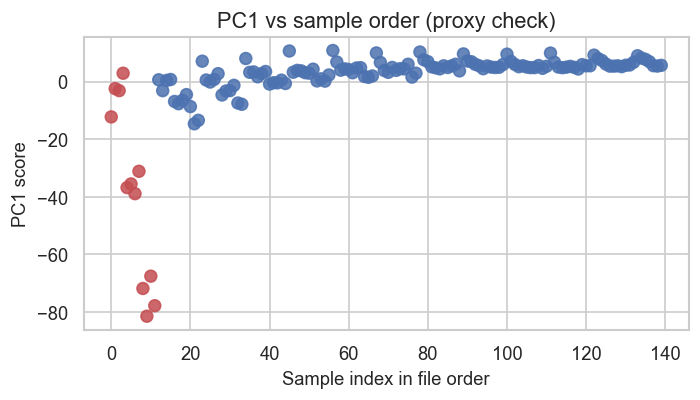

[Supplementary S1C] Correlation(sample order, PC1): r = 0.524


In [21]:
# S1C: Proxy sample order check using PC1 vs file order
order = np.arange(len(pca_df))
pc1 = pca_df.iloc[:, 0].values

corr = np.corrcoef(order, pc1)[0, 1]
print(f"Correlation between sample order and PC1: r = {corr:.3f}")

plt.figure(figsize=(6, 3.5))
plt.scatter(order, pc1, c=is_outlier.map({False: "#4C72B0", True: "#C44E52"}), s=50, alpha=0.85)
plt.xlabel("Sample index in file order")
plt.ylabel("PC1 score")
plt.title("PC1 vs sample order (proxy check)")
plt.tight_layout()
plt.show()
print(f"[Supplementary S1C] Correlation(sample order, PC1): r = {corr:.3f}")

In [22]:
# S4A: best k by silhouette across different PC counts (recording cluster sizes)
pc_grid = [2, 5, 8, 12, 20]
pc_sensitivity_full = pc_sensitivity_best_k(pca_full_df, pc_grid, k_max=20)
pc_sensitivity_clean = pc_sensitivity_best_k(pca_clean_df, pc_grid, k_max=20)

print("PC sensitivity (FULL):")
display(pc_sensitivity_full)

print("PC sensitivity (CLEAN):")
display(pc_sensitivity_clean)

PC sensitivity (FULL):


,n_pc,best_k_sil,best_sil,sizes
0,2,3,0.885848,"{0: 4, 1: 4, 2: 132}"
1,5,4,0.813405,"{0: 4, 1: 4, 2: 4, 3: 128}"
2,8,2,0.795715,"{0: 8, 1: 132}"
3,12,2,0.778689,"{0: 8, 1: 132}"
4,20,2,0.755554,"{0: 8, 1: 132}"


PC sensitivity (CLEAN):


,n_pc,best_k_sil,best_sil,sizes
0,2,2,0.493943,"{0: 40, 1: 88}"
1,5,2,0.367212,"{0: 41, 1: 87}"
2,8,2,0.327831,"{0: 39, 1: 89}"
3,12,2,0.303170,"{0: 38, 1: 90}"
4,20,2,0.281529,"{0: 38, 1: 90}"


In [27]:
# S4B: ARI stability across KMeans initializations
grid = [2,3,4,5,6,7,8,9,10]
for k in grid:
    m, s = ari_stability_init(X_pca_full.values, k=k, n_init=1)
    print(f"[FULL]  k={k} init-stability ARI: mean={m:.3f}, std={s:.3f}")

for k in grid:
    m, s = ari_stability_init(X_pca_clean.values, k=k, n_init=1)
    print(f"[CLEAN] k={k} init-stability ARI: mean={m:.3f}, std={s:.3f}")

[FULL]  k=2 init-stability ARI: mean=0.680, std=0.389
[FULL]  k=3 init-stability ARI: mean=0.739, std=0.241
[FULL]  k=4 init-stability ARI: mean=0.955, std=0.089
[FULL]  k=5 init-stability ARI: mean=0.696, std=0.322
[FULL]  k=6 init-stability ARI: mean=0.649, std=0.317
[FULL]  k=7 init-stability ARI: mean=0.793, std=0.264
[FULL]  k=8 init-stability ARI: mean=0.472, std=0.246
[FULL]  k=9 init-stability ARI: mean=0.561, std=0.217
[FULL]  k=10 init-stability ARI: mean=0.539, std=0.228
[CLEAN] k=2 init-stability ARI: mean=0.954, std=0.036
[CLEAN] k=3 init-stability ARI: mean=0.604, std=0.224
[CLEAN] k=4 init-stability ARI: mean=0.536, std=0.143
[CLEAN] k=5 init-stability ARI: mean=0.580, std=0.159
[CLEAN] k=6 init-stability ARI: mean=0.532, std=0.125
[CLEAN] k=7 init-stability ARI: mean=0.538, std=0.110
[CLEAN] k=8 init-stability ARI: mean=0.632, std=0.130
[CLEAN] k=9 init-stability ARI: mean=0.768, std=0.088
[CLEAN] k=10 init-stability ARI: mean=0.727, std=0.086


**Supplement S4B (Initialization stability, ARI):** Mean pairwise ARI across repeated KMeans runs with different random seeds using n_init=1 (single initialization) to isolate sensitivity to initialization. The clean dataset shows highest stability for K=2, supporting the main K selection.

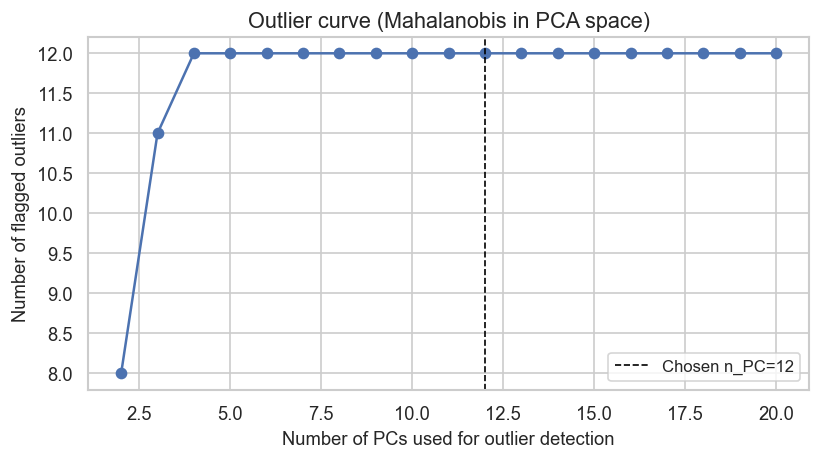

In [ ]:
from sklearn.decomposition import PCA
# (A) Outlier curve (Mahalanobis in PCA space) using LedoitWolf (consistent)
# Use the same scaled feature matrix as outlier detection (before PCA)
n_pc_grid = list(range(2, 21))
outlier_counts = {}

X_base = df_scaled_all  # should be the scaled matrix used for outlier flagging (140 x features)

for npc in n_pc_grid:
    pca_tmp = PCA(n_components=npc, random_state=42)
    Z = pca_tmp.fit_transform(X_base.values)

    lw = LedoitWolf().fit(Z)
    mu = lw.location_
    precision = lw.precision_

    d2 = np.einsum("ij,jk,ik->i", (Z - mu), precision, (Z - mu))
    thr = chi2.ppf(confidence_level, df=npc)
    outlier_counts[npc] = int((d2 > thr).sum())

chosen_n_pc_outlier = 12  # only if you still want to report this diagnostic

plt.figure(figsize=(7, 4))
plt.plot(list(outlier_counts.keys()), list(outlier_counts.values()), marker="o")
plt.axvline(chosen_n_pc_outlier, linestyle="--", color="black", linewidth=1, label=f"Chosen n_PC={chosen_n_pc_outlier}")
plt.title("Outlier curve (Mahalanobis in PCA space)")
plt.xlabel("Number of PCs used for outlier detection")
plt.ylabel("Number of flagged outliers")
plt.legend()
plt.tight_layout()
plt.show()

*Figure: Outlier count across PCA dimensions for Mahalanobis thresholding. A plateau suggests that the outlier count is not overly sensitive to the exact number of PCs used.*

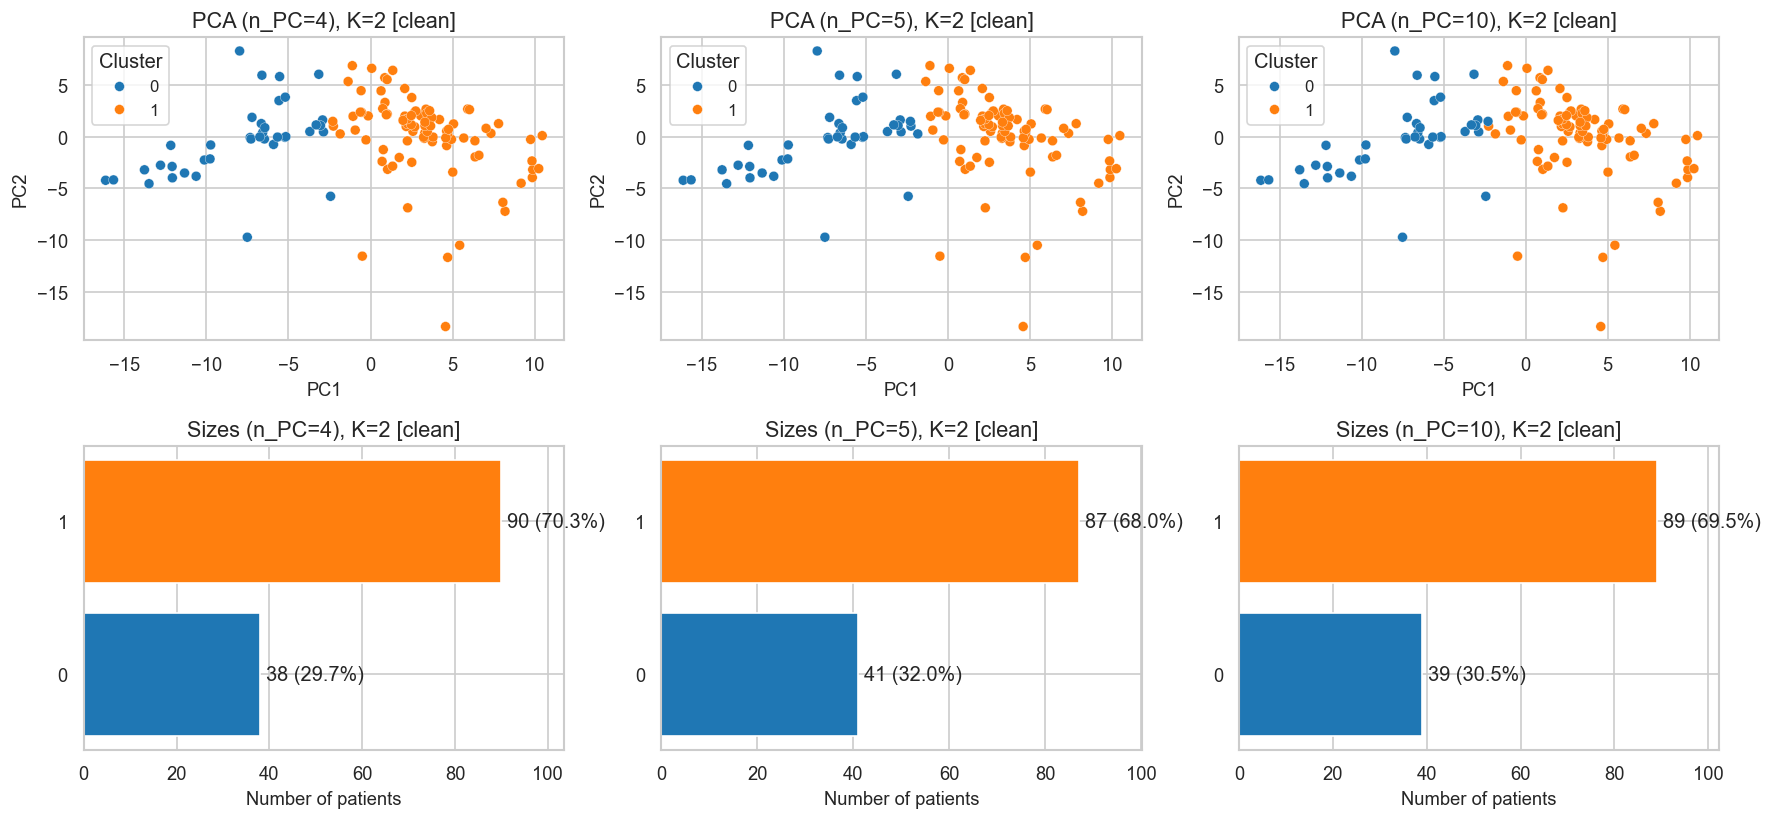

In [24]:
# (B) PCA dimension sensitivity for K=2 on CLEAN set
best_k = 2
pc_list = [4, 5, 10]

# Fit PCA ON CLEAN set once with max PCs, then slice columns
pca_max = PCA(n_components=max(pc_list), random_state=42)
Z_clean_max = pca_max.fit_transform(df_scaled_clean.values)
Z_clean_max = pd.DataFrame(Z_clean_max, index=df_scaled_clean.index,
                           columns=[f"PC{i+1}" for i in range(Z_clean_max.shape[1])])

fig, axes = plt.subplots(2, len(pc_list), figsize=(5 * len(pc_list), 7))

for j, npc in enumerate(pc_list):
    Xj = Z_clean_max.iloc[:, :npc].copy()
    labels_j = pd.Series(kmeans_cluster(Xj, n_clusters=best_k, align_labels=True),
                         index=Xj.index, name="label")

    emb2 = Xj.iloc[:, :2].copy()
    emb2.columns = ["PC1", "PC2"]
    plot_2d_embedding(emb2, labels_j, title=f"PCA (n_PC={npc}), K={best_k} [clean]", ax=axes[0, j])
    plot_cluster_sizes(labels_j, title=f"Sizes (n_PC={npc}), K={best_k} [clean]", ax=axes[1, j])

plt.tight_layout()
plt.show()

*Figure: Sensitivity of the K=2 partition to the number of retained PCs on the clean dataset. The qualitative separation and cluster sizes remain similar across multiple PCA dimensions.*

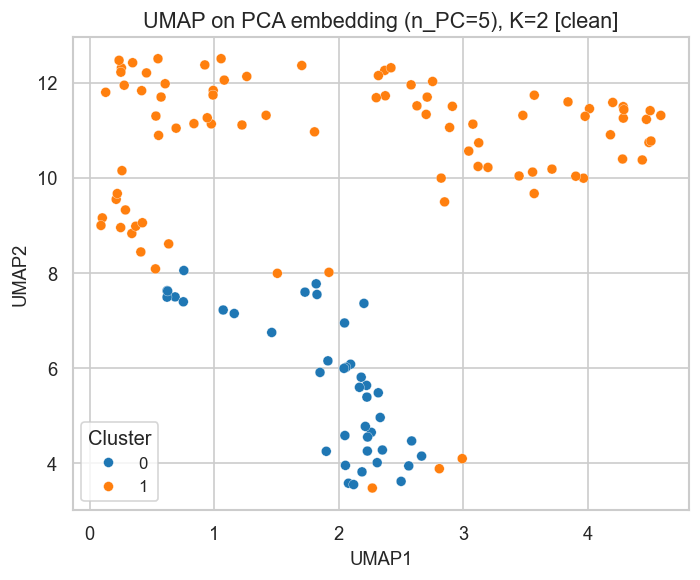

In [25]:
# (C) UMAP visualization (sanity check only) on CLEAN set
umap_df = apply_umap(X_pca_clean, n_components=2)
umap_df = umap_df.copy()
umap_df.columns = ["UMAP1", "UMAP2"]

plt.figure(figsize=(6, 5))
plot_2d_embedding(umap_df, labels_clean, title=f"UMAP on PCA embedding (n_PC={n_pc}), K={best_k} [clean]")
plt.tight_layout()
plt.show()

*Figure: UMAP visualization of clean patients using the same PCA embedding used for clustering (input to UMAP). This is a qualitative sanity check and not used to choose K.*

In [26]:
# (D) Assign outliers to nearest CLEAN centroid in the SAME PCA space (correct)
# Fit PCA on CLEAN set and transform OUTLIERS using the same PCA model
pca_main = PCA(n_components=n_pc, random_state=42)
Z_clean = pca_main.fit_transform(df_scaled_clean.values)
Z_out = pca_main.transform(df_scaled_outliers.values)

Z_clean = pd.DataFrame(Z_clean, index=df_scaled_clean.index, columns=[f"PC{i+1}" for i in range(n_pc)])
Z_out = pd.DataFrame(Z_out, index=df_scaled_outliers.index, columns=[f"PC{i+1}" for i in range(n_pc)])

# centroids in PCA space from CLEAN labels
unique_labels = np.sort(labels_clean.unique())
centroids = np.vstack([Z_clean.loc[labels_clean == lab].mean(axis=0).values for lab in unique_labels])

nearest_idx, _ = pairwise_distances_argmin_min(Z_out.values, centroids, metric="euclidean")
labels_out = pd.Series(unique_labels[nearest_idx], index=Z_out.index, name="label")

labels_all = pd.concat([labels_clean, labels_out]).to_frame()
labels_all.index.name = "Patient_ID"

labels_all.to_csv("../data/cluster_labels.csv")
print("Saved: ../data/cluster_labels.csv")
print("Label counts (all patients, including flagged extremes):")
print(labels_all["label"].value_counts().sort_index())

Saved: ../data/cluster_labels.csv
Label counts (all patients, including flagged extremes):
label
0    52
1    88
Name: count, dtype: int64


# 8. Conclusion

We implemented an unsupervised clustering pipeline to group bladder cancer patients based on proteomics profiles.

After log2 transformation and per patient median centering, we reduced dimensionality by selecting the top 20 percent most variable proteins (computed on the log2 scale) and standardizing the selected proteins using z scores per protein. We then applied PCA to obtain a lower dimensional embedding suitable for KMeans clustering.

We evaluated candidate cluster counts using inertia (elbow) and silhouette scores, and added robustness checks based on minimum cluster size, sensitivity to the number of retained PCs, and initialization stability across random seeds. For the stability diagnostic, we measured mean pairwise ARI across repeated runs with different random seeds using a single initialization per run (n init equals 1), while the final reported clustering uses multiple restarts to obtain a good solution.

A small number of extreme samples strongly affects KMeans behavior on the full dataset, producing tiny clusters that can inflate silhouette scores. After excluding these flagged extremes (clean dataset, n equals 128), the most defensible coarse partition is K equals 2. This solution shows moderate separation by silhouette, avoids tiny clusters, and is stable across random seeds on the clean dataset. The flagged extreme samples are retained for sensitivity reporting. For bookkeeping, they are projected into the same PCA space used for clustering (PCA fit on the clean set) and assigned to the nearest clean cluster centroid.

Cluster labels were saved to `../data/cluster_labels.csv` to support Level 2 analyses, for example identifying proteins and pathways associated with the clusters.